In [1]:
from __future__ import print_function, division

import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
import glob
import random
from PIL import Image
from tqdm import tqdm
import argparse
from bisect import bisect_right, bisect_left

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline

plt.ion()   # interactive mode


# Import data

In [2]:

def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor

In [3]:
#Import csv data from folders

imu_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv')
camera_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/data.csv')
vicon_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/vicon0/data.csv')

# Drop the first row of the camera

camera_data=camera_data.drop(camera_data.index[[0]])

# re-assign name to columns

vicon_data.columns = ['timestamp','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)


### Interpolate Vicon data to get data at the same timestamp of the camera and IMU
# Vicon data

vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()

# Create a new vicon dataframe with the same timestamps of the camera

idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new IMU dataframe with the same timestamps of the camera

idx_imu = return_idx(camera_timestamps, imu_data)
new_imu = imu_data.ix[idx_imu].reset_index(drop=True)
new_imu.drop(new_imu.tail(1).index,inplace=True) # drop last n rows

imu_timestamp = new_imu['timestamp'].values

# Create new dataframe for images and save it

image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',index = None, header=True)


# Let’s read the CSV and get the filenames and labels

file = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')
file.drop(file.tail(1).index,inplace=True) # drop last n rows
file.to_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/file.csv',index = None, header=True)



img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()

imu_pos_or = pd.read_csv('/home/francesca/Desktop/francesca/imu_pos_or.csv')
error_labels = pd.read_csv('/home/francesca/Desktop/francesca/error_labels.csv')


In [4]:
error_labels.head()
del imu_pos_or['Unnamed: 0']
del error_labels['Unnamed: 0']

In [5]:
result = pd.concat([file, error_labels], axis=1, join_axes=[file.index])

In [6]:
result.head()
del result['px']
del result['py']
del result['pz']
del result['qw']
del result['qx']
del result[ 'qy']
del result['qz']

In [7]:
result.head()

,timestamp,filename,0,1,2,3,4,5,6
0,1413394881605760512,1413394881605760512.png,0.000000,0.000000,0.000000,0.032357,-0.017586,-0.014970,0.000784
1,1413394881655760384,1413394881655760384.png,0.012269,0.041880,0.011034,0.032564,-0.019231,-0.011411,0.000759
2,1413394881705760512,1413394881705760512.png,-0.008650,0.061907,0.021087,0.042423,-0.010986,-0.016171,0.000686
3,1413394881755760384,1413394881755760384.png,0.001891,0.047778,0.016587,0.030963,-0.012714,-0.013419,0.000771
4,1413394881805760512,1413394881805760512.png,0.002131,0.049233,0.015041,0.034317,-0.013903,-0.009962,0.000730


In [8]:
result.head()
result.to_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/result.csv',index = None, header=True)



In [9]:
imu_pos_or = imu_pos_or
imu_pos_or.to_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/imu_pos_or_new.csv',index = None, header=True)

error_labels_matrix = error_labels.as_matrix()

## Create Customized Dataset 

In [10]:
class NewDataset(Dataset):
    def __init__(self, csv_file, imu_data, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.imu_data = imu_data
        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data.iloc[:, 1:].as_matrix()

        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir
        # Transforms
        transformation = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop((64,96)),
            transforms.ToTensor(),
#             transforms.Normalize([0.4543, 0.4543, 0.4543],[0.3035, 0.3035, 0.3035])
        ])
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)
        transform_imu = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transform_imu = transform_imu
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
#         image = PIL.Image.open(fp + single_image_name).convert('RGB')
        image = Image.open(fp + single_image_name).convert('RGB')
        image = self.transform(image)
        imu_data = self.imu_arr[idx]
#         imu_data = self.transform_imu( imu_data)
        # Get label of the image based on the cropped pandas column
        labels = self.label_arr[idx]

        return image, imu_data, labels

In [12]:
bs=32

dataset = NewDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/result.csv', 
                         imu_data=imu_pos_or,
                           root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')
#load the data
dataloader = DataLoader(dataset, batch_size=bs,shuffle=False)


#### Split into Training and Validation 

In [14]:
batch_size = 32
validation_split = .2
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)



# Functions

In [15]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

# Feature Extractore Network +  Regressor for Camera translation and rotation

In [16]:
class IMUNet(torch.nn.Module):

    def __init__(self, feature_extractor, num_features=128, dropout=0.5,
                 track_running_stats=False, pretrained=False):
        super(IMUNet, self).__init__()
        self.dropout = dropout
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        
        self.fc1 = torch.nn.Linear(6,100)
        self.fc2 = torch.nn.Linear( 3200,32)

        self.fc3 = torch.nn.Linear( num_features + 1, num_features)
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)

        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def extract_features(self, image):
        x_features = self.feature_extractor(image)
        x_features = F.relu(x_features)
        if self.dropout > 0:
            x_features = F.dropout(x_features, p=self.dropout, training=self.training)
        return x_features
    
    def forward(self, data_input):
        image = data_input[0].cuda()
        imu_data = data_input[1].unsqueeze(0).type(torch.FloatTensor).cuda()
        #Images
        if type(image) is list:
            x_features = [self.extract_features(xi) for xi in image]
        elif torch.is_tensor(image):
            x_features = self.extract_features(image)
            
            
#         imu_features = imu_data.view(-1, 1495680)
        imu_features = F.relu(self.fc1(imu_data))
        imu_features = imu_features.view(imu_features.size()[0], -1)
        imu_features = F.relu(self.fc2(imu_features))

        imu_features=imu_features.view(32, -1)
        x = torch.cat((x_features, imu_features), dim=1)
        x = F.relu(self.fc3(x))

        if type(x) is list:
#             x_features = [self.extract_features(xi) for xi in x]
            x_translations = [self.fc_xyz(xi) for xi in x]
            x_rotations = [self.fc_quat(xi) for xi in x]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
#             x_features = self.extract_features(x)
            x_translations = self.fc_xyz(x) 
            x_rotations = self.fc_quat(x)
            x_poses = torch.cat((x_translations, x_rotations), dim=1)

        return x_poses

In [18]:
import torchvision.models as models
import torch.optim as optim
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)



In [20]:
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)


out = model(next(iter(dataloader))[0:2])
out.size()


torch.Size([32, 7])

In [21]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)


In [24]:
class NetCriterion(torch.nn.Module):
    def __init__(self, beta = 216.0):
        super(NetCriterion, self).__init__()
        self.loss_fn1 = torch.nn.L1Loss()
        self.loss_fn = torch.nn.MSELoss()
        self.beta = beta
    
    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) - prediction (xyz, quat)
            y: list(N x 7, N x 7) - target (xyz, quat)
        """
        
        loss = 0
        # Translation loss
        loss =   (self.loss_fn(x[:, :3], y[:, :3])+0.01*self.loss_fn1(x[:, :3], y[:, :3])) 
        # Rotation loss
        loss +=   self.beta * self.loss_fn(x[:, 3:], y[:, 3:]+0.01*self.loss_fn1(x[:, 3:], y[:, 3:])) 

        return loss

In [26]:
import torchvision.models as models
import torch.optim as optim
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048



In [27]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count

In [36]:
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    position_loss=[]
    orientation_loss = []
    
    model.train()
    losses = AverageMeter()
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    end = time.time()
    
    for idx, data in enumerate(train_loader):
        batch_images= data[0].cuda()
        imu_data= data[1].unsqueeze(0).cuda()
    
        batch_poses= data[2].cuda()
        data_time = (time.time() - end)
        batch_images = batch_images.to(device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
#         imu_data = imu_data.to(device).double()
        imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)
        out = model(data[0:2])


        loss = criterion(out, batch_poses)
        
        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), len(batch_images) * batch_images.size(0))
        
        
        # move data to cpu & numpy
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
        t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
        q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])
    position_loss.append(t_loss)
    orientation_loss.append(q_loss)
   
    return losses
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    position_loss_testing=[]
    orientation_loss_testing=[]
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, data in enumerate(val_loader):


            batch_images= data[0].cuda()
            imu_data= data[1].unsqueeze(0).cuda()
        
            batch_poses= data[2].cuda()
            data_time = time.time() - end
            
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
            batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
            imu_data = imu_data.to(device)
            imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


            # compute model output
            out = model(data[:2])
            loss = criterion(out, batch_poses)
            
            losses.update(loss.item(), len(batch_images) * batch_images.size(0))
            batch_time = time.time() - end
            end = time.time()
#             print(idx % log_freq)
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))

    return losses


In [37]:
import torchvision.models as models
import torch.optim as optim

# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048


imu = next(iter(train_loader))[1]
# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
criterion = NetCriterion()
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]


# Create optimizer
# optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)
optimizer = optim.Adam(params=param_list, lr=0.0001, weight_decay=0.0005)


# Epochs to train
start_epoch = 0

# n_epochs = 10

In [38]:
n_epochs = start_epoch + 200
train_loss=[]
test_loss=[]
print('Training ...')
val_freq = 10
for e in range(start_epoch, n_epochs):
    losses = train(train_loader, model, criterion, optimizer, e, n_epochs, log_freq=100)
    train_loss.append(losses)
    if e % val_freq == 0:
#         end = time.time()
        loss = validate(validation_loader, model, criterion, e, log_freq=100)
        test_loss.append(loss)


start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))

Training ...
Epoch: [0/199]	Batch: [0/47]	Time: 0.176	Data Time: 0.143	Loss: 110.426	Avg Loss: 110.426	
Val Epoch: 0	Time: 0.157	Data Time: 0.148	Loss: 8.778	Avg Loss: 8.778
Epoch: [1/199]	Batch: [0/47]	Time: 0.174	Data Time: 0.144	Loss: 7.748	Avg Loss: 7.748	
Epoch: [2/199]	Batch: [0/47]	Time: 0.173	Data Time: 0.144	Loss: 5.259	Avg Loss: 5.259	
Epoch: [3/199]	Batch: [0/47]	Time: 0.174	Data Time: 0.145	Loss: 3.303	Avg Loss: 3.303	
Epoch: [4/199]	Batch: [0/47]	Time: 0.177	Data Time: 0.147	Loss: 2.282	Avg Loss: 2.282	
Epoch: [5/199]	Batch: [0/47]	Time: 0.172	Data Time: 0.142	Loss: 1.916	Avg Loss: 1.916	
Epoch: [6/199]	Batch: [0/47]	Time: 0.172	Data Time: 0.142	Loss: 2.544	Avg Loss: 2.544	
Epoch: [7/199]	Batch: [0/47]	Time: 0.171	Data Time: 0.140	Loss: 4.227	Avg Loss: 4.227	
Epoch: [8/199]	Batch: [0/47]	Time: 0.172	Data Time: 0.143	Loss: 2.460	Avg Loss: 2.460	
Epoch: [9/199]	Batch: [0/47]	Time: 0.174	Data Time: 0.144	Loss: 1.523	Avg Loss: 1.523	
Epoch: [10/199]	Batch: [0/47]	Time: 0.171	D

Epoch: [86/199]	Batch: [0/47]	Time: 0.173	Data Time: 0.142	Loss: 0.435	Avg Loss: 0.435	
Epoch: [87/199]	Batch: [0/47]	Time: 0.173	Data Time: 0.143	Loss: 0.233	Avg Loss: 0.233	
Epoch: [88/199]	Batch: [0/47]	Time: 0.175	Data Time: 0.145	Loss: 0.359	Avg Loss: 0.359	
Epoch: [89/199]	Batch: [0/47]	Time: 0.175	Data Time: 0.146	Loss: 0.490	Avg Loss: 0.490	
Epoch: [90/199]	Batch: [0/47]	Time: 0.179	Data Time: 0.148	Loss: 0.895	Avg Loss: 0.895	
Val Epoch: 90	Time: 0.159	Data Time: 0.151	Loss: 4.312	Avg Loss: 4.312
Epoch: [91/199]	Batch: [0/47]	Time: 0.173	Data Time: 0.142	Loss: 0.609	Avg Loss: 0.609	
Epoch: [92/199]	Batch: [0/47]	Time: 0.174	Data Time: 0.143	Loss: 0.775	Avg Loss: 0.775	
Epoch: [93/199]	Batch: [0/47]	Time: 0.172	Data Time: 0.142	Loss: 0.894	Avg Loss: 0.894	
Epoch: [94/199]	Batch: [0/47]	Time: 0.176	Data Time: 0.145	Loss: 0.450	Avg Loss: 0.450	
Epoch: [95/199]	Batch: [0/47]	Time: 0.171	Data Time: 0.142	Loss: 0.692	Avg Loss: 0.692	
Epoch: [96/199]	Batch: [0/47]	Time: 0.178	Data Ti

Epoch: [171/199]	Batch: [0/47]	Time: 0.176	Data Time: 0.145	Loss: 0.328	Avg Loss: 0.328	
Epoch: [172/199]	Batch: [0/47]	Time: 0.171	Data Time: 0.140	Loss: 0.280	Avg Loss: 0.280	
Epoch: [173/199]	Batch: [0/47]	Time: 0.174	Data Time: 0.143	Loss: 0.362	Avg Loss: 0.362	
Epoch: [174/199]	Batch: [0/47]	Time: 0.175	Data Time: 0.144	Loss: 0.324	Avg Loss: 0.324	
Epoch: [175/199]	Batch: [0/47]	Time: 0.172	Data Time: 0.144	Loss: 0.726	Avg Loss: 0.726	
Epoch: [176/199]	Batch: [0/47]	Time: 0.171	Data Time: 0.142	Loss: 1.442	Avg Loss: 1.442	
Epoch: [177/199]	Batch: [0/47]	Time: 0.170	Data Time: 0.141	Loss: 0.578	Avg Loss: 0.578	
Epoch: [178/199]	Batch: [0/47]	Time: 0.169	Data Time: 0.139	Loss: 1.051	Avg Loss: 1.051	
Epoch: [179/199]	Batch: [0/47]	Time: 0.175	Data Time: 0.145	Loss: 0.261	Avg Loss: 0.261	
Epoch: [180/199]	Batch: [0/47]	Time: 0.176	Data Time: 0.148	Loss: 0.435	Avg Loss: 0.435	
Val Epoch: 180	Time: 0.153	Data Time: 0.145	Loss: 6.864	Avg Loss: 6.864
Epoch: [181/199]	Batch: [0/47]	Time: 0

In [145]:
def model_results_pred_gt(model, dataloader):
    
    model.eval()

    gt_d_poses = np.empty((0, 7))
    pred_d_poses = np.empty((0, 7))

    for idx, data in enumerate(dataloader):
        batch_images = data[0].cuda()
        batch_imu = data[1].cuda()
        batch_poses  = data[2].cuda()
        batch_images = batch_images.to(device)
        batch_imu = batch_imu.to(device)
        batch_imu = torch.tensor(batch_imu, dtype=torch.float, device=device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        out = model(data[0:2])        
        loss = criterion(out, batch_poses)
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_d_poses = np.vstack((gt_d_poses, bp))
        pred_d_poses = np.vstack((pred_d_poses, outp))


    gt_d_poses[:, :3] = gt_d_poses[:, :3] 
    pred_d_poses[:, :3] = pred_d_poses[:, :3] 
    
    return pred_d_poses, gt_d_poses

print('\n=== Test Training Dataset ======')
pred_d_poses, gt_d_poses = model_results_pred_gt(model, train_loader)

print('gt_d_poses = {}'.format(gt_d_poses.shape))
print('pred_d_poses = {}'.format(pred_d_poses.shape))
d_t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_d_poses[:, :3], gt_d_poses[:, :3])])
d_q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_d_poses[:, 3:], gt_d_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(d_t_loss), np.mean(d_t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(d_q_loss), np.mean(d_q_loss)))

# Save for later visualization
pred_d_poses_train = pred_d_poses
gt_d_poses_train = gt_d_poses





=== Test Training Dataset ======
gt_d_poses = (1536, 7)
pred_d_poses = (1536, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.003, mean = 0.003
R: median = 1.482, mean = 5.133


In [146]:
print('\n=== Test Validation Dataset ======')
pred_d_poses, gt_d_poses = model_results_pred_gt(model, validation_loader)

print('gt_poses = {}'.format(gt_d_poses.shape))
print('pred_poses = {}'.format(pred_d_poses.shape))
d_t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_d_poses[:, :3], gt_d_poses[:, :3])])
d_q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_d_poses[:, 3:], gt_d_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(d_t_loss), np.mean(d_t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(d_q_loss), np.mean(d_q_loss)))

# Save for later visualization
pred_d_poses_val = pred_d_poses
gt_d_poses_val = gt_d_poses


=== Test Validation Dataset ======
gt_poses = (384, 7)
pred_poses = (384, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.009, mean = 0.010
R: median = 88.228, mean = 67.935


In [149]:
pose_prediction=pred_d_poses_val[:,:3]
pose_prediction_train = pred_d_poses_train[:,:3] 
imu_integration = imu_pos_or.as_matrix()
imu_integration_pose = imu_integration[:,:3]

position_training = imu_integration_pose[:(1920-384),:] + pose_prediction_train
ground_truth_training = labels[:(1920-384),:3]

position_testing = imu_integration_pose[(1920-384):,:] + pose_prediction
ground_truth_testing = labels[(1920-384):,:3]

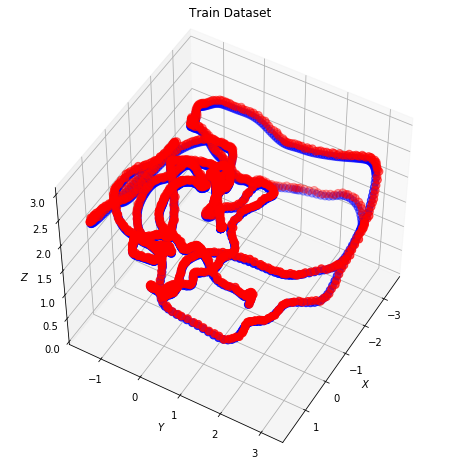

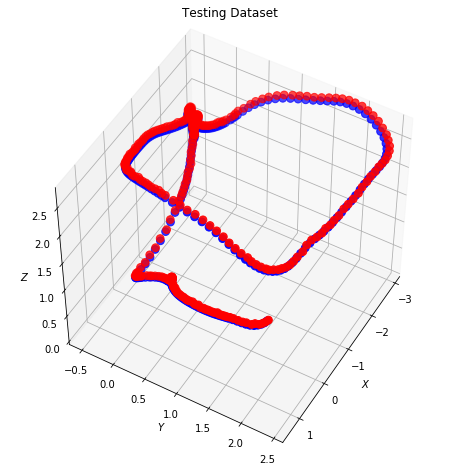

In [151]:
from mpl_toolkits.mplot3d import Axes3D

def calc_poses_params(poses, pose_format='full-mat'):
    """Calculates min, max, mean and std of translations of the poses"""

    p = poses[0]
    allp = extract_translation(p, pose_format)

    for p in poses[1:]:
        allp = np.vstack((allp, extract_translation(p, pose_format)))

    p_min = np.min(allp, axis=0)
    p_max = np.max(allp, axis=0)
    p_mean = np.mean(allp, axis=0)
    p_std = np.std(allp, axis=0)

    return p_min, p_max, p_mean, p_std

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def extract_translation(p, pose_format='full-mat'):
    if pose_format == 'full-mat':
        return p[0:3, 3]
    elif pose_format == 'quat':
        return p[:3]
    else:
        warnings.warn("pose_format should be either 'full-mat' or 'quat'")
        return p


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()
    
def draw_poses(ax, poses, c='b', s=20, proj=False, proj_z=0, pose_format='quat'):

    coords = np.zeros((len(poses), 3))
    for i, p in enumerate(poses):
        # coords[i] = p[:3, 3]
        # coords[i] = p
        coords[i] = extract_translation(p, pose_format=pose_format)

    # Draw projection
    if proj:
        if len(poses) > 1:
            ax.plot(coords[:, 0], coords[:, 1], proj_z, c='g')
        elif len(poses) == 1:
            ax.scatter(coords[:, 0], coords[:, 1], proj_z, c=c)

    # Draw path
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=c, s=s)


def draw_poses_list(ax, poses_list):
    """Draw list of lists of poses."""
    for poses in poses_list:
        draw_poses(ax, poses)


# Draw predicted vs ground truth poses
draw_pred_gt_poses(position_training, ground_truth_training)
plt.title('Train Dataset')
plt.show()

# Draw predicted vs ground truth poses
draw_pred_gt_poses(position_testing, ground_truth_testing)
plt.title('Testing Dataset')
plt.show()



Text(0, 0.5, 'meters')

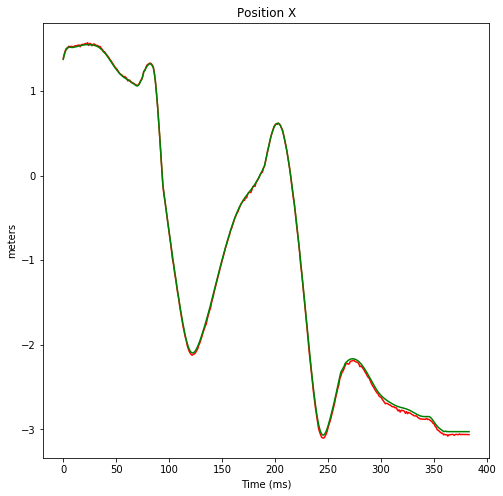

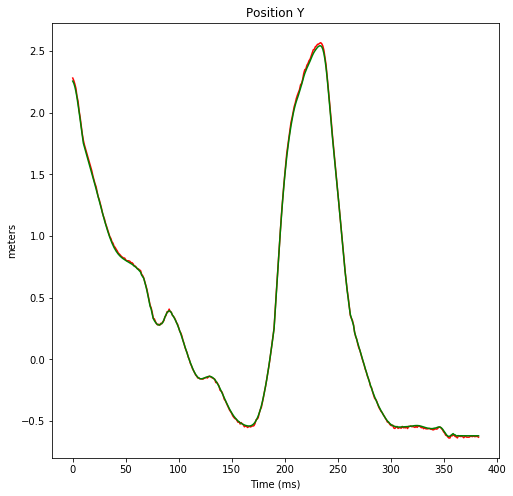

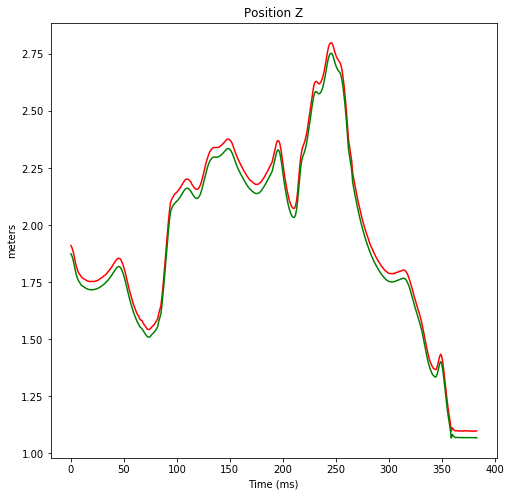

In [152]:
fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( position_testing[:,0], 'r')
plt.plot(ground_truth_testing[:,0], 'g')
# plt.plot(time, gyrZ, 'b')
plt.title('Position X')
plt.xlabel('Time (ms)')
plt.ylabel('meters')

fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( position_testing[:,1], 'r')
plt.plot(ground_truth_testing[:,1], 'g')
# plt.plot(time, gyrZ, 'b')
plt.title('Position Y')
plt.xlabel('Time (ms)')
plt.ylabel('meters')


fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( position_testing[:,2], 'r')
plt.plot(ground_truth_testing[:,2], 'g')
# plt.plot(time, gyrZ, 'b')
plt.title('Position Z')
plt.xlabel('Time (ms)')
plt.ylabel('meters')






In [153]:
error_x=[]
error_y=[]
error_z=[]
for i in range(len(position_testing)):
    error_x.append(np.linalg.norm(position_testing[i,0] - ground_truth_testing[i,0]))
    error_y.append(np.linalg.norm(position_testing[i,1] - ground_truth_testing[i,1]))
    error_z.append(np.linalg.norm(position_testing[i,2] - ground_truth_testing[i,2]))

Text(0, 0.5, 'meters')

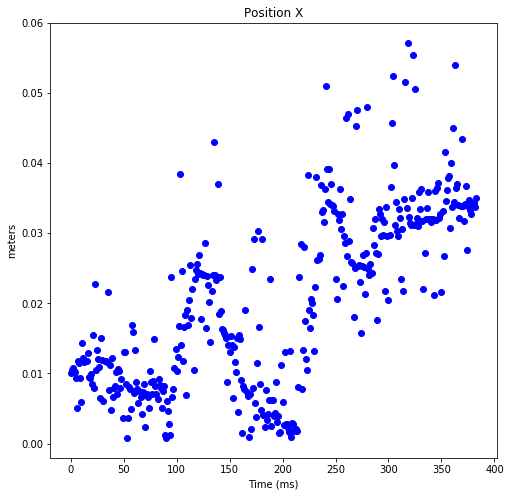

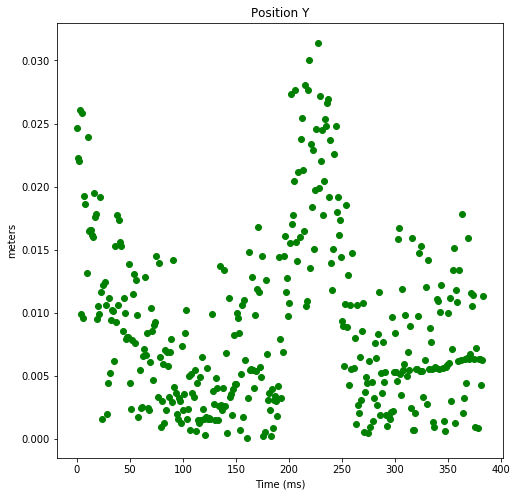

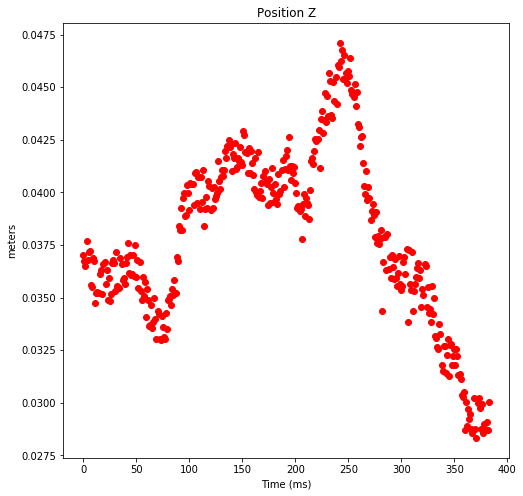

In [154]:
fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( error_x, 'bo')
# plt.plot(time, gyrZ, 'b')
plt.title('Position X')
plt.xlabel('Time (ms)')
plt.ylabel('meters')

fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( error_y, 'go')
# plt.plot(time, gyrZ, 'b')
plt.title('Position Y')
plt.xlabel('Time (ms)')
plt.ylabel('meters')


fig = plt.figure(figsize=(8, 8))

# ax(1) = subplot(2,1,1);
plt.plot( error_z, 'ro')
# plt.plot(time, gyrZ, 'b')
plt.title('Position Z')
plt.xlabel('Time (ms)')
plt.ylabel('meters')






In [155]:
def save_checkpoint(model, optimizer, criterion, experiment_name='test', epoch=None,
                    time_str=None):
    if not time_str:
        time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = '{}_{}'.format(time_str, experiment_name)
    if epoch is not None:
        fname += '_e{:03d}'.format(epoch)
    fname += '.pth.tar'

    checkpoints_dir = '_checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    fname_path = os.path.join(checkpoints_dir, fname)

    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict()
    }
    
    if criterion.learn_beta:
        checkpoint_dict.update({'criterion_state_dict': criterion.state_dict()})

    torch.save(checkpoint_dict, fname_path)

    return fname_path



experiment_name = 'IMU_Camera_new_mav0_best'

#  Save checkpoint
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)

'_checkpoints/20190527_095513_nb_IMU_Camera_new_mav0_best_e500.pth.tar'